**Dylan Govender - 221040222**

# **1 Importing Dataset**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [9]:
!cp '/content/gdrive/My Drive/Colab Notebooks/sentiment_dataset.csv' 'sentiment_dataset.csv'

In [10]:
!sudo apt-get install recode
!recode -f utf8 sentiment_dataset.csv

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
recode is already the newest version (3.6-24build2).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [11]:
import pandas as pd

df = pd.read_csv("//content//sentiment_dataset.csv")
df.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
df.head()

# target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
# ids: The id of the tweet (2087)
# date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
# flag: The query (lyx). If there is no query, then this value is NO_QUERY.
# user: the user that tweeted (robotickilldozr)
# text: the text of the tweet (Lyx is cool)

,target,ids,date,flag,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


# **2 Preprocessing**

In [5]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [12]:
import regex as re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

lemmatizer = nltk.stem.WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words('english')

def remove_columns(dataframe):
    unnecessary_columns = ['ids', 'date', 'flag', 'user']
    dataframe = dataframe.drop(columns=unnecessary_columns)
    return dataframe

def convert_sentiment(dataframe):
    dataframe['target'] = dataframe['target'].map({0: 'negative', 2: 'neutral', 4: 'positive'})
    return dataframe

def preprocessing(text):
    text = re.sub(r"@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+", " ", (text.lower()).strip())
    clean_text = []
    for word in text.split():
        if word not in stopwords:
            clean_text.append(lemmatizer.lemmatize(word))
    return (" ".join(clean_text)).lower()

df = remove_columns(df)
df = convert_sentiment(df)

df['clean_text'] = df['text'].apply(lambda text : preprocessing(text))
df.head()

,target,text,clean_text
0,negative,is upset that he can't update his Facebook by ...,upset update facebook texting might cry result...
1,negative,@Kenichan I dived many times for the ball. Man...,dived many time ball managed save 50 rest go b...
2,negative,my whole body feels itchy and like its on fire,whole body feel itchy like fire
3,negative,"@nationwideclass no, it's not behaving at all....",behaving mad see
4,negative,@Kwesidei not the whole crew,whole crew


In [14]:
df["text"] = df["clean_text"]
del df["clean_text"]
df.head()

,target,text
0,negative,upset update facebook texting might cry result...
1,negative,dived many time ball managed save 50 rest go b...
2,negative,whole body feel itchy like fire
3,negative,behaving mad see
4,negative,whole crew


In [15]:
df.describe()

,target,text
count,1599999,1599999
unique,2,1480392
top,positive,
freq,800000,7683


In [16]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

sum_len = sum([len(text) for text in df["text"]])
max_len = len(df["text"])
MAX_SEQ_LEN = sum_len//max_len

# Cross-Validation
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_set.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size:", vocab_size)

x_train = pad_sequences(tokenizer.texts_to_sequences(train_set.text), maxlen=MAX_SEQ_LEN)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_set.text), maxlen=MAX_SEQ_LEN)

labels = train_set.target.unique().tolist()

encoder = LabelEncoder()
encoder.fit(train_set.target.to_list())

y_train = encoder.transform(train_set.target.to_list())
y_test = encoder.transform(test_set.target.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

Vocabulary Size: 279283


In [20]:
from tabulate import tabulate

print("X_TRAIN SHAPE:", x_train.shape)
print("Y_TRAIN SHAPE:", y_train.shape)
print("X_TEST SHAPE:", x_test.shape)
print("Y_TEST SHAPE:", y_test.shape)

print("\nX_TRAIN SAMPLE:")
print(tabulate([x_train[0][30:].tolist()], tablefmt='fancy_grid'))

print("\nY_TRAIN SAMPLE:")
print(tabulate([y_train[0].tolist()], tablefmt='fancy_grid'))

print("\nX_TEST SAMPLE:")
print(tabulate([x_test[0][25:].tolist()], tablefmt='fancy_grid'))

print("\nY_TEST SAMPLE:")
print(tabulate([y_test[0].tolist()], tablefmt='fancy_grid'))

X_TRAIN SHAPE: (1279999, 42)
Y_TRAIN SHAPE: (1279999, 1)
X_TEST SHAPE: (320000, 42)
Y_TEST SHAPE: (320000, 1)

X_TRAIN SAMPLE:
╒═══╤═══╤═══╤═══╤═══╤═══╤═══╤═══╤═════╤═══╤════╤════╕
│ 0 │ 0 │ 0 │ 0 │ 0 │ 0 │ 0 │ 0 │ 487 │ 3 │ 16 │ 44 │
╘═══╧═══╧═══╧═══╧═══╧═══╧═══╧═══╧═════╧═══╧════╧════╛

Y_TRAIN SAMPLE:
╒═══╕
│ 1 │
╘═══╛

X_TEST SAMPLE:
╒═══╤═══╤═══╤═══╤═════╤════╤═══════╤═══════╤══════╤════╤═════╤════╤════╤═════╤═════╤════╤═════╕
│ 0 │ 0 │ 0 │ 0 │ 241 │ 96 │ 10010 │ 21260 │ 2328 │ 19 │ 143 │ 38 │ 87 │ 171 │ 197 │ 57 │ 322 │
╘═══╧═══╧═══╧═══╧═════╧════╧═══════╧═══════╧══════╧════╧═════╧════╧════╧═════╧═════╧════╧═════╛

Y_TEST SAMPLE:
╒═══╕
│ 0 │
╘═══╛


In [21]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2024-05-14 11:11:50--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-05-14 11:11:51--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-05-14 11:11:51--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

# **3 GRU - Training and Evaluation**

In [22]:
import numpy as np

embeddings_index = {}

# using a custom pretrained word embedding
GLOVE_EMBEDDING_PATH = "//content//glove.6B.300d.txt"
file = open(GLOVE_EMBEDDING_PATH)
for line in file:
    values = line.split()
    word = value = values[0]
    coefficient = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefficient
file.close()

print("Found %s word vectors." %len(embeddings_index))

Found 400000 word vectors.


In [23]:
import tensorflow

EMBEDDING_DIM = 300
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_layer = tensorflow.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQ_LEN,
                                          trainable=False)

In [24]:
import tensorflow
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, SpatialDropout1D, GRU, Dropout, Dense
from tensorflow.keras.callbacks import ModelCheckpoint

model = Sequential(name="GRU")
model.add(embedding_layer)
model.add(SpatialDropout1D(0.2))
model.add(GRU(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(GRU(128))
model.add(Dense(512, activation='relu',
                kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01)))
model.add(Dense(1, activation='sigmoid'))

In [25]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

LEARNING_RATE = 1e-3

# Compile the model
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy'])

# Create early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')

# Create ReduceLROnPlateau callback
reduce_learning_rate = ReduceLROnPlateau(factor=0.1, min_lr=0.01, monitor='val_loss', verbose=1)

In [26]:
model.summary()

Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 42, 300)           83784900  
                                                                 
 spatial_dropout1d (Spatial  (None, 42, 300)           0         
 Dropout1D)                                                      
                                                                 
 gru (GRU)                   (None, 42, 128)           165120    
                                                                 
 dropout (Dropout)           (None, 42, 128)           0         
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
 dense (Dense)               (None, 512)               66048     
                                                               

In [27]:
BATCH_SIZE = 1024
EPOCHS = 10

history = model.fit(x_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(x_test, y_test),
                    callbacks=[early_stopping, reduce_learning_rate])

Epoch 1/10
1250/1250 [==============================] - 55s 36ms/step - loss: 0.5862 - accuracy: 0.7425 - val_loss: 0.4914 - val_accuracy: 0.7694 - lr: 0.0010
Epoch 2/10
1250/1250 [==============================] - 46s 37ms/step - loss: 0.4949 - accuracy: 0.7656 - val_loss: 0.4784 - val_accuracy: 0.7737 - lr: 0.0010
Epoch 3/10
1250/1250 [==============================] - 48s 38ms/step - loss: 0.4823 - accuracy: 0.7717 - val_loss: 0.4691 - val_accuracy: 0.7802 - lr: 0.0010
Epoch 4/10
1250/1250 [==============================] - 48s 39ms/step - loss: 0.4748 - accuracy: 0.7755 - val_loss: 0.4640 - val_accuracy: 0.7831 - lr: 0.0010
Epoch 5/10
1250/1250 [==============================] - 48s 38ms/step - loss: 0.4694 - accuracy: 0.7784 - val_loss: 0.4611 - val_accuracy: 0.7837 - lr: 0.0010
Epoch 6/10
1250/1250 [==============================] - 49s 39ms/step - loss: 0.4650 - accuracy: 0.7810 - val_loss: 0.4583 - val_accuracy: 0.7850 - lr: 0.0010
Epoch 7/10
1250/1250 [========================

# **4 GRU Evaluation**

In [28]:
loss, accuracy = model.evaluate(x_test, y_test)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

10000/10000 [==============================] - 59s 6ms/step - loss: 0.4536 - accuracy: 0.7880
Test Loss: 0.4536186158657074
Test Accuracy: 0.7879531383514404


In [29]:
from sklearn.metrics import classification_report

def decode_sentiment(score):
    return "positive" if score>0.5 else "negative"

scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]
print(classification_report(list(test_set.target), y_pred_1d))

32/32 [==============================] - 4s 91ms/step
              precision    recall  f1-score   support

    negative       0.79      0.79      0.79    159494
    positive       0.79      0.79      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



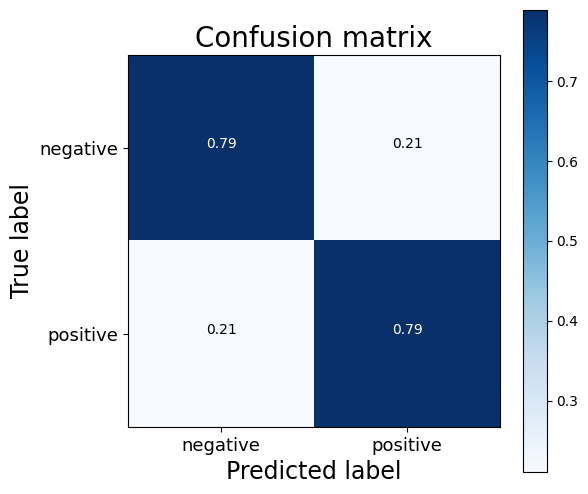

In [30]:
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

cnf_matrix = confusion_matrix(test_set.target.to_list(), y_pred_1d)
plot_confusion_matrix(cnf_matrix, classes=test_set.target.unique(), title="Confusion matrix")
plt.show()